<a href="https://colab.research.google.com/github/rj7shakya/music_composition/blob/master/music_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls '/content/drive/My Drive/beeth'

appass_1.mid		       beethoven_opus10_1.mid  mond_1.mid
appass_2.mid		       beethoven_opus10_2.mid  mond_2.mid
appass_3.mid		       beethoven_opus10_3.mid  mond_3.mid
beethoven_hammerklavier_1.mid  beethoven_opus22_1.mid  pathetique_1.mid
beethoven_hammerklavier_2.mid  beethoven_opus22_2.mid  pathetique_2.mid
beethoven_hammerklavier_3.mid  beethoven_opus22_3.mid  pathetique_3.mid
beethoven_hammerklavier_4.mid  beethoven_opus22_4.mid  waldstein_1.mid
beethoven_les_adieux_1.mid     beethoven_opus90_1.mid  waldstein_2.mid
beethoven_les_adieux_2.mid     beethoven_opus90_2.mid  waldstein_3.mid
beethoven_les_adieux_3.mid     elise.mid


In [0]:
from music21 import *

In [0]:
track=0
# reading midi file 
def read_midi(file):
  print("Loading music file",file)
  notes=[]
  notes_to_parse=None
  midi = converter.parse(file)
  midi = midi[track]
  notes_to_parse = midi.flat.notes

  # s2 = instrument.partitionByInstrument(midi)
  # for part in s2.parts:
  #   if 'Piano' in str(part):
  #     notes_to_parse = part.recurse()
  for element in notes_to_parse:
    if isinstance(element, note.Note):
      notes.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
      notes.append('.'.join(str(n) for n in element.normalOrder))
  
  return np.array(notes)

In [5]:
import os
import numpy as np
path='/content/drive/My Drive/beeth/'

files=[i for i in os.listdir(path) if i.endswith(".mid")]

notes_array = np.array([read_midi(path+i) for i in files])

Loading music file /content/drive/My Drive/beeth/beethoven_opus90_1.mid
Loading music file /content/drive/My Drive/beeth/beethoven_opus22_2.mid
Loading music file /content/drive/My Drive/beeth/beethoven_opus22_3.mid
Loading music file /content/drive/My Drive/beeth/beethoven_hammerklavier_1.mid
Loading music file /content/drive/My Drive/beeth/appass_2.mid
Loading music file /content/drive/My Drive/beeth/pathetique_1.mid
Loading music file /content/drive/My Drive/beeth/beethoven_opus22_1.mid
Loading music file /content/drive/My Drive/beeth/beethoven_hammerklavier_2.mid
Loading music file /content/drive/My Drive/beeth/beethoven_les_adieux_3.mid
Loading music file /content/drive/My Drive/beeth/pathetique_2.mid
Loading music file /content/drive/My Drive/beeth/elise.mid
Loading music file /content/drive/My Drive/beeth/waldstein_1.mid
Loading music file /content/drive/My Drive/beeth/waldstein_2.mid
Loading music file /content/drive/My Drive/beeth/beethoven_opus10_1.mid
Loading music file /con

In [6]:
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
pitches = unique_notes
vocab_length = len(pitches)  
number_notes = len(notes_)

print(pitches)
print(notes_)

['11.2.4', 'E-3', '1', '8.1', '5.11', 'C#4', '8.10.11', 'D4', 'B-3', '11.2.6', '1.3.6', '4.7.10.0', 'G6', 'B5', '3', '5.9.11', '1.4.6', 'B-1', 'B4', 'A5', 'G#4', '10.0.5', 'C2', '2.5.7', '0.5', '8.11.3', 'G#3', '9.10', '3.6.9.11', '6.11', '3.5.8', '9.2', '0.1', 'E4', '9.11', 'G#6', '9.1', '10.1.4', '10.0.4', '4.7.11', 'B1', 'G3', 'C#3', '8.11.1', 'F#5', '4.7.9', '1.5', 'A2', '1.3.7', 'F#3', '1.5.7', 'F5', '11.2.4.6', 'B2', '9.0.2', '1.4', '2.5.8.11', 'E-6', '7.10.0', 'C6', 'C4', '7.11', '2.7.8', '4.7.10', 'E7', '6.8.0', 'G5', '9.0.3.5', '11', '6.10', '6.9.11', '11.3', 'E2', '0.3.6', '5.8.11.1', '2.8', '1.2.5.8', '6.9.0', '2.6.8', '1.4.7', '10.0', '2.5.8.10', '11.2.5', '4.8', 'G#2', '6.10.1', 'E-2', '10.0.3', '9.0.4', '1.4.8', '3.7.10', '11.3.6', '2.7', '10', '10.0.3.6', '0.3.7', '2.6.7', 'F6', '4.6.10', '10.3', '11.1', '2.3', 'A4', 'D5', 'D3', '6.9.0.2', '0.3.5', '9.1.3', '3.5', '3.5.9', 'B-6', '4.6', '11.1.5', 'A1', '2.5.8', '9', '1.4.7.10', '7', 'F3', '3.7', 'B6', '0.2', '7.8.0', '8.

In [0]:
note_dict = dict()
for i, note in enumerate(pitches):
  note_dict[note] = i

sequence_length = 50

num_training = number_notes - sequence_length

input_notes = np.zeros((num_training, sequence_length, vocab_length))
output_notes = np.zeros((num_training, vocab_length))

for i in range(0, num_training):
    # Here, i is the training example, j is the note in the sequence for a specific training example
    input_sequence = notes_[i: i+sequence_length]
    output_note = notes_[i+sequence_length]
    for j, note in enumerate(input_sequence):
        input_notes[i][j][note_dict[note]] = 1
    output_notes[i][note_dict[output_note]] = 1

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, vocab_length)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(vocab_length))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

history = model.fit(input_notes, output_notes, batch_size=128, nb_epoch=100)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Epoch 1/100
42315/42315 [==============================] - 167s 4ms/step - loss: 3.9322 - acc: 0.0784
Epoch 2/100
42315/42315 [==============================] - 160s 4ms/step - loss: 3.2888 - acc: 0.1471
Epoch 3/100
42315/42315 [==============================] - 162s 4ms/step - loss: 3.0880 - acc: 0.1696
Epoch 4/100
42315/42315 [==============================] - 166s 4ms/step - loss: 2.9784 - acc: 0.1823
Epoch 5/100
42315/42315 [==============================] - 163s 4ms/step - loss: 2.9044 - acc: 0.1938
Epoch 6/100
42315/42315 [==============================] - 164s 4ms/step - loss: 2.8365 - acc: 0.2033
Epoch 7/100
42315/42315 [==============================] - 169s 4ms/step - loss: 2.7756 - acc: 0.2186
Epoch 8/100
42315/42315 [==============================] - 167s 4ms/step - loss: 2.7135 - acc: 0.2372
Epoch 9/100
42315/42315 [==============================] - 167s 4ms/step - loss: 2.6493 - acc: 0.2562
Epoch 10/100
42315/42315 [==============================] - 164s 4ms/step - loss: 

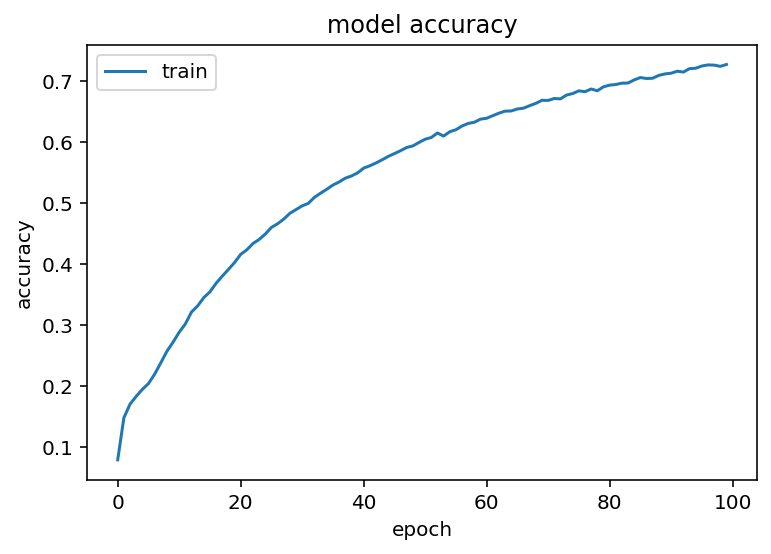

In [9]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
model.save("music.hdf5")

In [0]:
# generating music 

backward_dict = dict()
for note in note_dict.keys():
  index = note_dict[note]
  backward_dict[index] = note

n = np.random.randint(0, len(input_notes)-1)
sequence = input_notes[n]
start_sequence = sequence.reshape(1, sequence_length, vocab_length)
output = []

for i in range(0, 100):
  newNote = model.predict(start_sequence, verbose=0)
  # Get the position with the highest probability
  index = np.argmax(newNote)
  encoded_note = np.zeros((vocab_length))
  encoded_note[index] = 1
  output.append(encoded_note)
  sequence = start_sequence[0][1:]
  start_sequence = np.concatenate((sequence, encoded_note.reshape(1, vocab_length)))
  start_sequence = start_sequence.reshape(1, sequence_length, vocab_length)


In [12]:
from music21 import note

finalNotes = [] 
for element in output:
    index = list(element).index(1)
    finalNotes.append(backward_dict[index])
    
offset = 0
output_notes = []

for pattern in finalNotes:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    # increase offset each iteration so that notes do not stack
    offset += 0.5

midi_stream = stream.Stream(output_notes)

midi_stream.write('midi', fp='test_output.mid')

'test_output.mid'